In [2]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import DistanceMetric
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import os

warnings.filterwarnings("ignore", category=Warning) 
sns.set_style("ticks")
sns.set_context("talk")

**1 - baixe os dados**

estao em Data/Raw/Country_data.csv

**2 - Import os dados / Quantos países existem no dataset?**

In [3]:
df = pd.read_csv("Data/Raw/Country_data.csv") #pd.read_csv(os.getcwd()+"\\..\\..\\Data\\Raw\\Country_data.csv")
df= df.set_index("country")


count = df.index.value_counts().sum()
print(f'Os números de Países no DF são: {count}')

Os números de Países no DF são: 167


In [10]:
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


**3 - Questão** 

*1º Etapa -* Mostre através de gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização.

*2º Etapa -* Analise os resultados mostrados. O que deve ser feito com os dados antes da etapa de clusterização?

1º Etapa

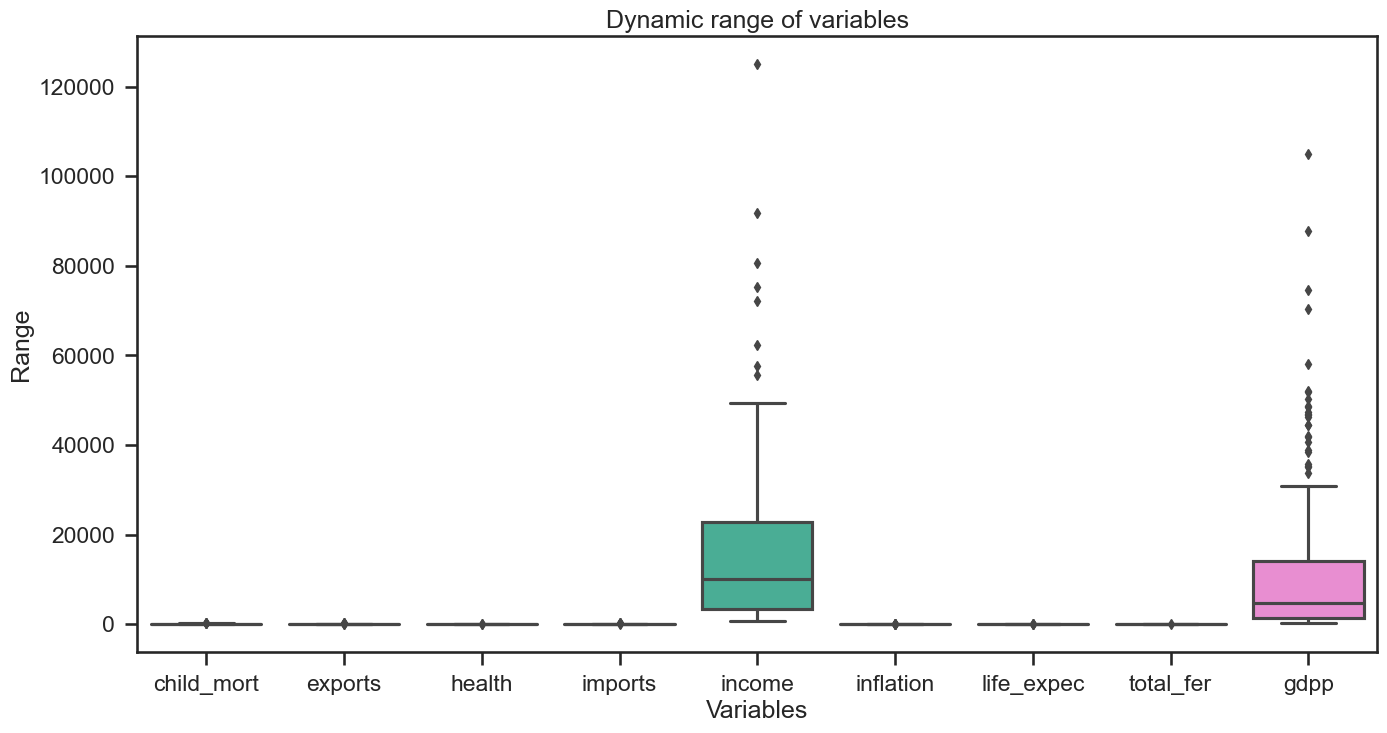

In [3]:
plt.figure(figsize=(16,8))
plt.title('Dynamic range of variables')
plt.xlabel('Variables')
plt.ylabel('Range')
sns.boxplot(df)
plt.show();

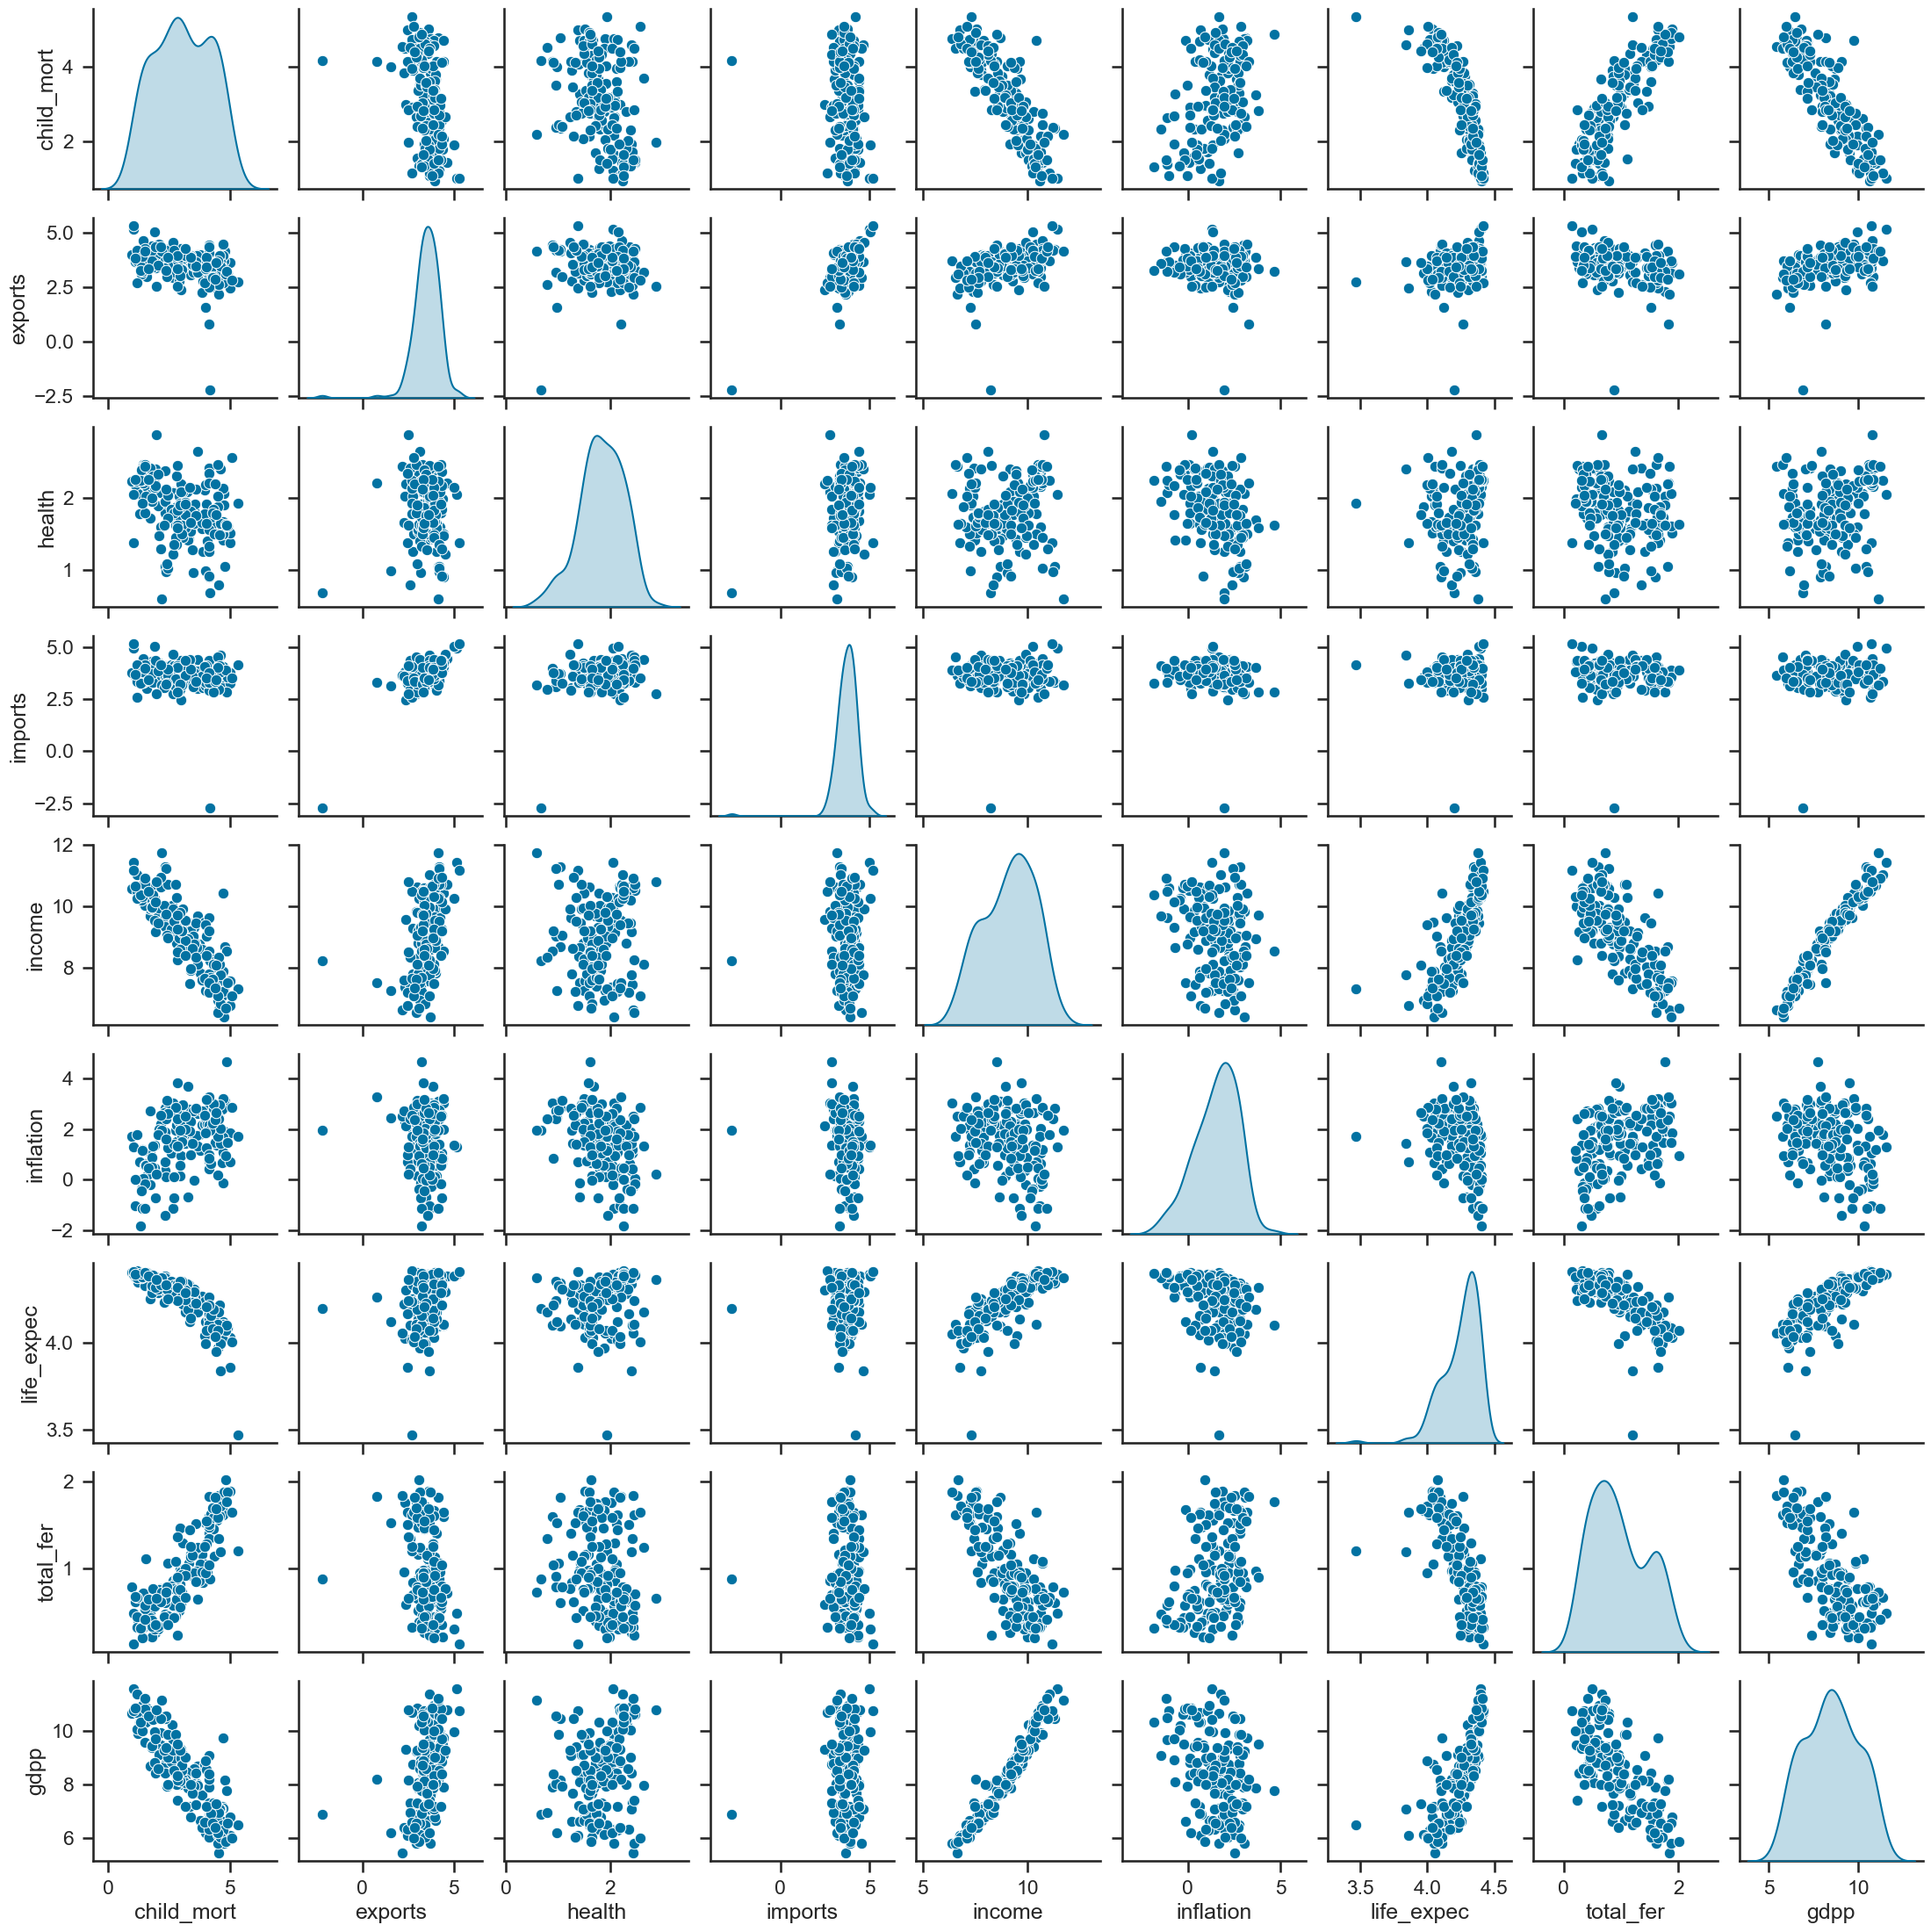

In [13]:

sns.pairplot(np.log(df), diag_kind="kde");

*2º Etapa -*

Através do gráfico acima, percebemos duas variaveis com distribuição exponencial com calda longa, sendo assim, iremos usar logaritimo nestas duas váriaveis antes do pré-processamento usando o Scaled.

Foi identificado também um País com outlier(Ver código abaixo) nas variáveis *'imports'* e *'exports'*. *'Myanmar'* mostrou esse outlier e por isso, devido a sensibilidade do k-médias a outilier, iremos excluí-lo. Além disso, verificamos que o DataFrame não possui dados nulos. 

Todas essas etapas de verificar *outlier's, nulos e tipos de variáveis*, são importantes e devem ser feitas antes do pré-processamento

Verificação de dados nulos

In [3]:
df.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Verificação e exclusão do outlier **Myanmar**

In [4]:
print(f"Importações Myanmar : {df.imports.sort_values()[0]}")

print(f"Exportações Myanmar: {df.exports.sort_values()[0]}")

Importações Myanmar : 0.0659
Exportações Myanmar: 0.109


In [5]:
df.drop(index='Myanmar', inplace=True)

Usando logarítimo nas variaveis *'income'* e *'gdpp'*, para diminuirmos a discrepância em relação aos demais dados. 

In [6]:
df_log = df.copy()
df_log['income'] = np.log(df_log.income)
df_log['gdpp'] = np.log(df_log.gdpp)


**4º QUESTÃO**

Realize o pré-processamento adequado dos dados. Devido a quantidade de variáveis, e similaridade nos resultados, decidi não usar PCA na preparação dos dados.

In [7]:
scaler = StandardScaler()

scaled_data = pd.DataFrame(scaler.fit_transform(df_log),
                           columns=df_log.columns,
                           index=df_log.index)
scaled_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,1.291532,-1.138280,0.279088,-0.082455,-1.413059,0.157336,-1.619092,1.902882,-1.460560
Albania,-0.538949,-0.479658,-0.097016,0.070837,0.071749,-0.312347,0.647866,-0.859973,-0.122592
Algeria,-0.272833,-0.099122,-0.966073,-0.641762,0.285304,0.789274,0.670423,-0.038404,-0.064683
Angola,2.007808,0.775381,-1.448071,-0.165315,-0.353135,1.387054,-1.179234,2.128151,-0.221051
Antigua and Barbuda,-0.695634,0.160668,-0.286894,0.497568,0.605603,-0.601749,0.704258,-0.541946,0.608191


ETAPA DE CLUSTERIZAÇÃO

**1º QUESTÃO**

Realizar o agrupamento dos países em 3 grupos distintos. Para tal, use:

*ETAPA A -*  K-Médias

*ETAPA B -*  Clusterização Hierárquica

*ETAPA-A*

Para termos 3 cluster's conforme determina a questão, usamos o Metódo KMeans com o parâmetro n_clusters = 3 e random_state.

In [8]:
model_kmeans = KMeans(
    n_clusters=3,  
    n_init=100,     
    max_iter=1000,
    random_state=0) 

clusters_kmeans = model_kmeans.fit_predict(scaled_data)

#inserindo as predições de CLuster no df
df_cluster = df.copy()
df_cluster_scale = scaled_data.copy()
df_cluster['clusters_kmeans'] = clusters_kmeans
df_cluster_scale['clusters_kmeans'] = clusters_kmeans

df_cluster.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters_kmeans
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2


*ETAPA-B*

Para termos 3 cluster's conforme determina a questão, usamos o Metódo AgglomerativeClustering com o parâmetro n_clusters = 3.



In [9]:
model_hierar = AgglomerativeClustering(n_clusters=3)
clusters_hierar = model_hierar.fit_predict(scaled_data)

df_cluster_scale['clusters_hierar'] = clusters_hierar
df_cluster['clusters_hierar'] = clusters_hierar
df_cluster.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters_kmeans,clusters_hierar
country,,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0,1
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1,0
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1,0
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0,1
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2,0


**QUESTÃO 02**

Para os resultados, do K-Médias:

a)Interprete cada um dos clusters obtidos citando:
   - Etapa 01  - Qual a distribuição das dimensões em cada grupo;
   - Etapa 02 - O país, de acordo com o algoritmo, melhor representa o seu agrupamento. Justifique.


**Etapa 01**

Para sabermos as dimenssoes de cada Grupo iremos ver a quantidade de Países em cada Cluster e após isso alguns gráficos para melhor entender.

In [10]:
Counter(clusters_kmeans)

Counter({1: 43, 2: 65, 0: 58})

Como visto, temos no Clusters: 

*   **Cluster 0: 58 Países**
*   **Cluster 1: 43 Países**
*   **Cluster 2: 65 Países**

Abaixo, temos, uma descrição detalhada dos Países em cada cluster, representação gráfica  e um Describe de cada Cluster.

List of Countries in cluster 0, total 58 countries:
      
       'Antigua and Barbuda', 'Australia', 'Austria', 'Bahamas', 'Bahrain',
       'Barbados', 'Belgium', 'Bosnia and Herzegovina', 'Brunei', 'Bulgaria',
       'Canada', 'Chile', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kuwait',
       'Latvia', 'Lebanon', 'Lithuania', 'Luxembourg', 'Malaysia', 'Maldives',
       'Malta', 'Mauritius', 'Montenegro', 'Netherlands', 'New Zealand',
       'Norway', 'Panama', 'Poland', 'Portugal', 'Qatar', 'Serbia',
       'Seychelles', 'Singapore', 'Slovak Republic', 'Slovenia', 'South Korea',
       'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates',
       'United Kingdom', 'United States', 'Uruguay'
********************************************************************************
Describe Cluster 0
       child_mort     exports     health  

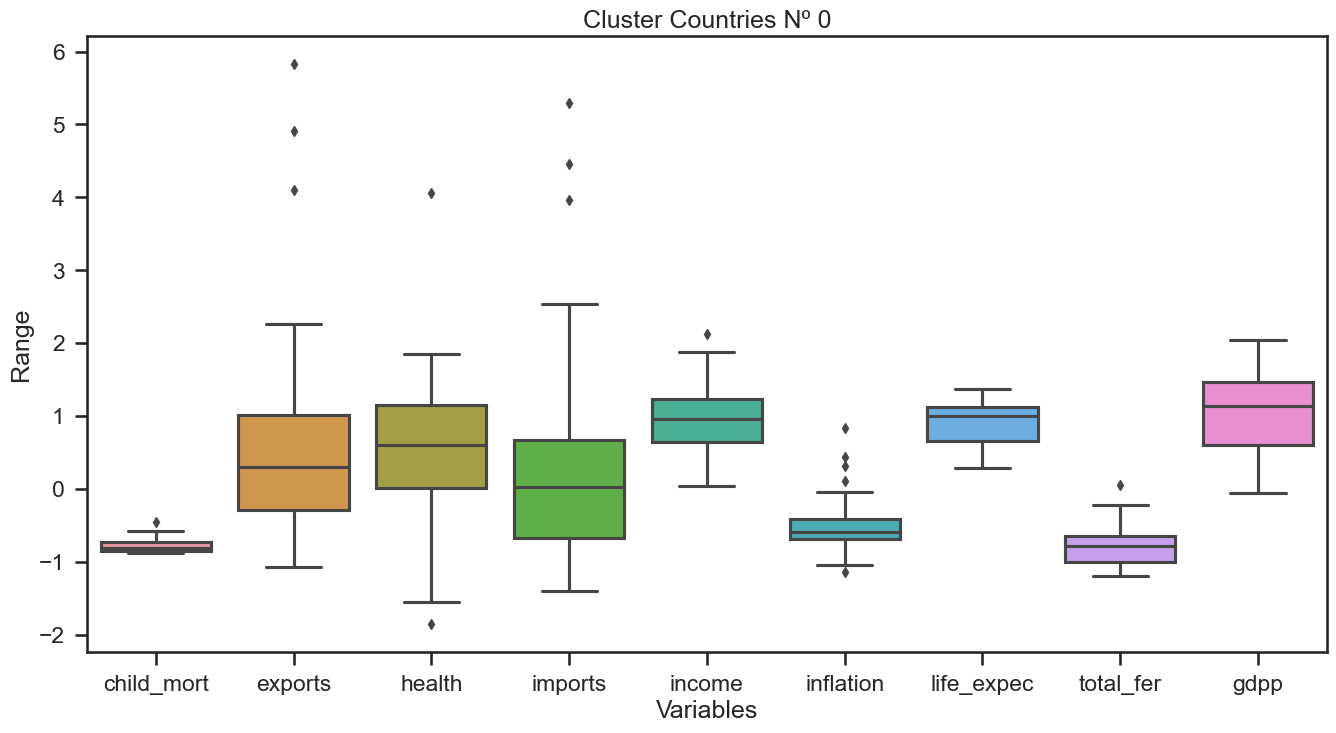

List of Countries in cluster 1, total 43 countries:
      
       'Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi', 'Cameroon',
       'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Cote d'Ivoire', 'Eritrea', 'Gambia', 'Ghana', 'Guinea',
       'Guinea-Bissau', 'Haiti', 'Kenya', 'Kiribati', 'Lao', 'Lesotho',
       'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique',
       'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone',
       'Solomon Islands', 'Sudan', 'Tajikistan', 'Tanzania', 'Timor-Leste',
       'Togo', 'Uganda', 'Yemen', 'Zambia'
********************************************************************************
Describe Cluster 1
       child_mort   exports    health     imports       income   inflation  \
count   43.000000  43.00000  43.00000   43.000000    43.000000   43.000000   
mean    94.788372  26.31186   6.38093   43.667442  2177.279070   11.797791   
std     33.834029  15.99668  

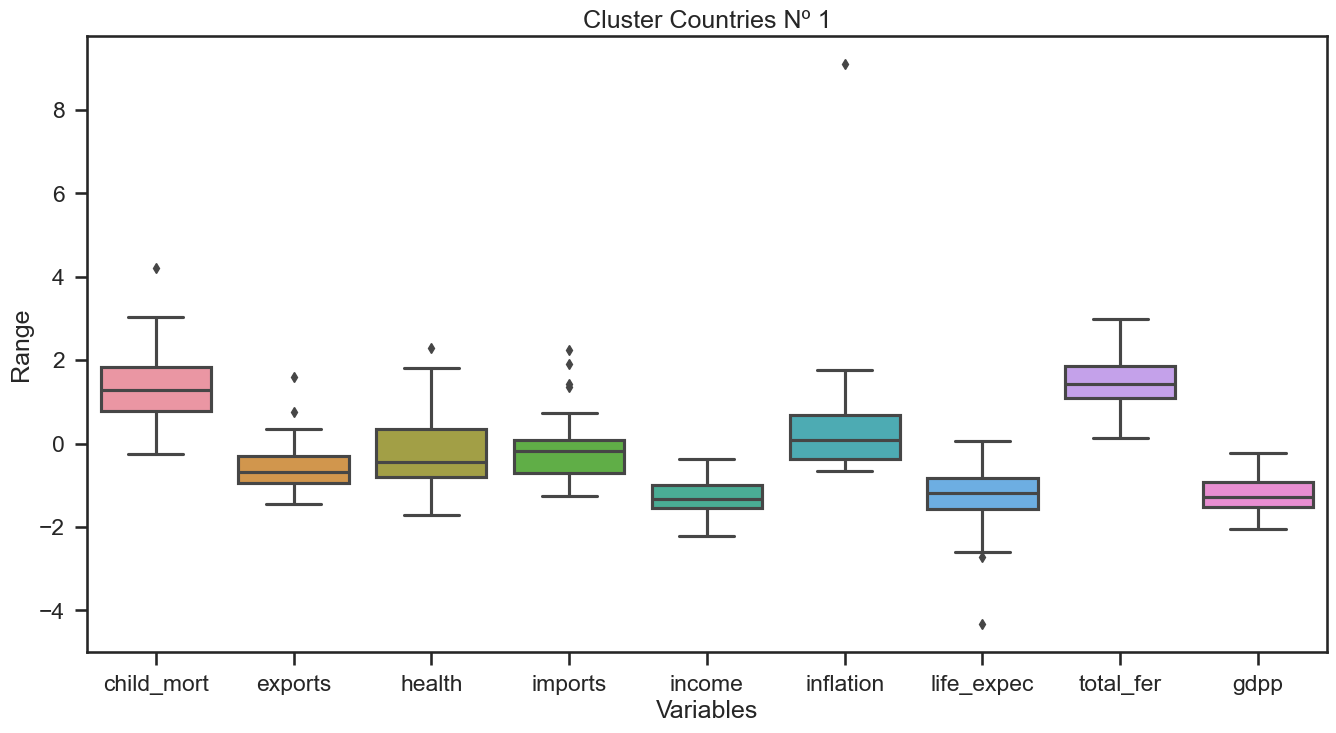

List of Countries in cluster 2, total 65 countries:
      
       'Albania', 'Algeria', 'Argentina', 'Armenia', 'Azerbaijan',
       'Bangladesh', 'Belarus', 'Belize', 'Bhutan', 'Bolivia', 'Botswana',
       'Brazil', 'Cambodia', 'Cape Verde', 'China', 'Colombia',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Fiji', 'Gabon', 'Georgia', 'Grenada', 'Guatemala',
       'Guyana', 'India', 'Indonesia', 'Iran', 'Iraq', 'Jamaica', 'Jordan',
       'Kazakhstan', 'Kyrgyz Republic', 'Libya', 'Macedonia, FYR',
       'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Morocco', 'Namibia',
       'Nepal', 'Oman', 'Paraguay', 'Peru', 'Philippines', 'Romania', 'Russia',
       'Samoa', 'Saudi Arabia', 'South Africa', 'Sri Lanka',
       'St. Vincent and the Grenadines', 'Suriname', 'Thailand', 'Tonga',
       'Tunisia', 'Turkey', 'Turkmenistan', 'Ukraine', 'Uzbekistan', 'Vanuatu',
       'Venezuela', 'Vietnam'
**********************************************

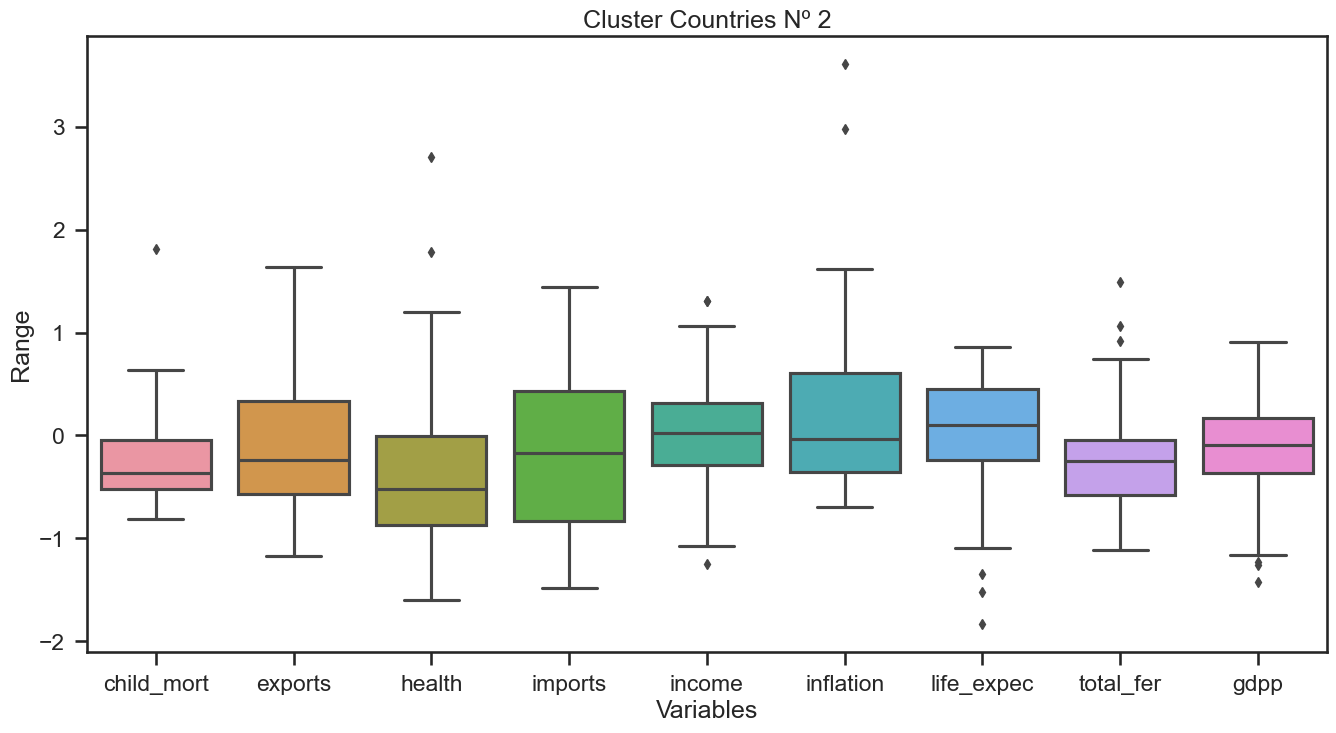

In [13]:
def analyze_cluster(df_cluster_scale, df_cluster,cluster='clusters_kmeans'):   
   for i in range(3):    
      cluster_number = df_cluster_scale[df_cluster_scale[cluster]==i].drop(  
                                             ['clusters_hierar','clusters_kmeans'], axis=1)
      
      print(f"""List of Countries in cluster {i}, total {cluster_number.value_counts().sum()} countries:
      \n       {str(df_cluster_scale[df_cluster_scale['clusters_kmeans']==i].index)[7:-40]}""")
      
      print('*'*80)
      print(f'Describe Cluster {i}')
      
      print(f"""\033[2;30;47m{
         df_cluster[df_cluster[cluster]==i].drop(['clusters_hierar','clusters_kmeans'], axis=1).describe()
         }\033[0m""")    
      
      print('*'*80)
      print(f"Boxplot cluster {i}")
      plt.figure(figsize=(16,8))
      plt.title(f'Cluster Countries Nº {i}')
      plt.xlabel('Variables')
      plt.ylabel('Range')
      sns.boxplot(cluster_number)
      plt.show();
      

analyze_cluster(df_cluster_scale, df_cluster,'clusters_kmeans' )

Uma visão geral por meio de um pairplot 

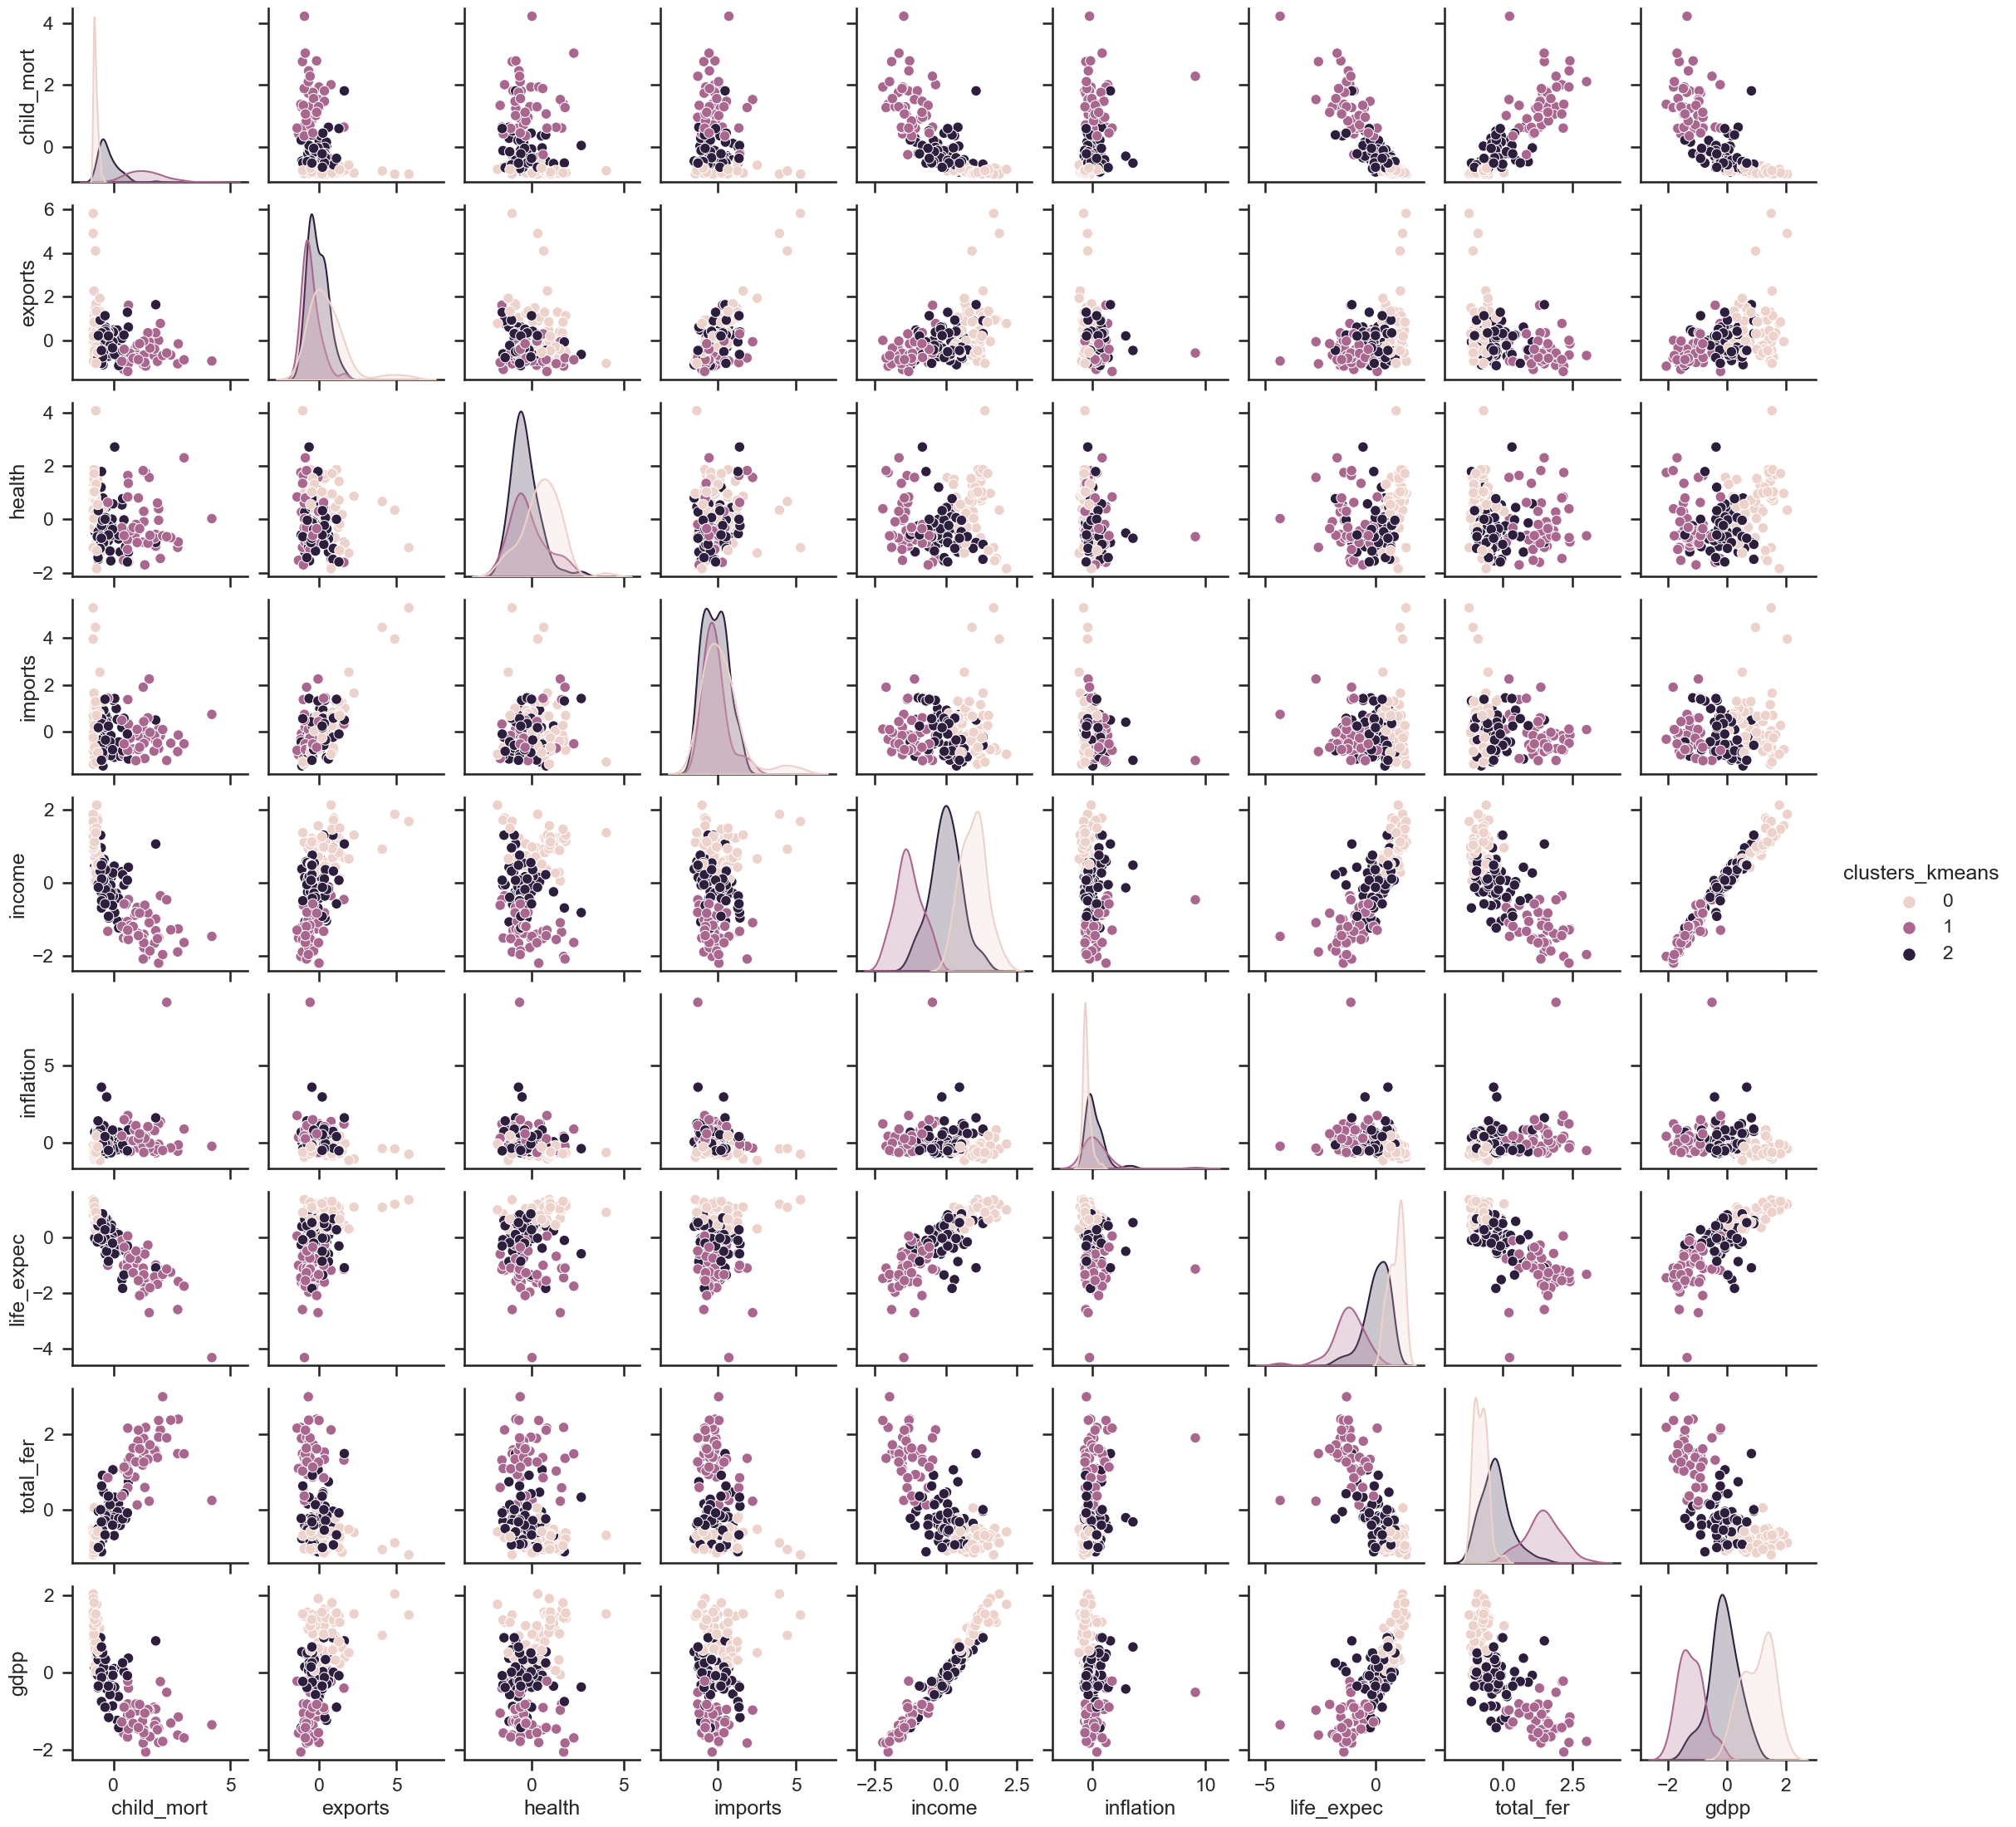

In [14]:
sns.pairplot(df_cluster_scale.drop('clusters_hierar', axis=1),hue='clusters_kmeans', diag_kind="kde");

**Etapa 02**

Escolhendo o País que melhor representa seu cluster, qual País tem melhor distância média entre os pontos. Para isso usaremos o sklearn, Numpy e Scipy.

*OBS1:* Ambos os metódos fazem a mesma coisa, porém, por questões de aprendizado temos a demonstração matemática. 

*OBS2:* Esses melhores pontos escolhidos em cada cluster nada mais é que o medoide, ou ponto mais próximo do centroide.

Usando scipy.spatial.distance

In [11]:
def find_best_point(cluster, cluster_id):
    df_cluster = df_cluster_scale[df_cluster_scale['clusters_kmeans'] == cluster].drop(['clusters_kmeans', 'clusters_hierar'], axis=1)
    distances = pdist(df_cluster.values, metric='euclidean')    
    distance_matrix = squareform(distances)
    total_distances = np.sum(distance_matrix, axis=1)
    best_point_index = np.argmin(total_distances)
    best_point = df_cluster.iloc[best_point_index].name.upper()
    print(f"O País com melhor ponto médio do cluster {cluster_id} é: \033[2;30;47;3m{best_point}\033[0m - Distância: {total_distances[best_point_index]}")


for cluster_id in range(3):
    find_best_point(cluster_id, cluster_id)


O País com melhor ponto médio do cluster 0 é: SOUTH KOREA - Distância: 115.94973190076024
O País com melhor ponto médio do cluster 1 é: TANZANIA - Distância: 96.44218891883862
O País com melhor ponto médio do cluster 2 é: JAMAICA - Distância: 121.08737732440713


Usando sklearn.pairwise_distance

In [16]:
for i in range(3): 
    df_distance = df_cluster_scale[df_cluster_scale['clusters_kmeans']==i].drop(['clusters_kmeans','clusters_hierar'], axis=1)
    distances = pairwise_distances(df_distance.values)
    total_distances = distances.sum(axis=1)
    best_point_index = total_distances.argmin()
    best_point = df_distance.iloc[best_point_index].name.upper()
    print(f"O País com melhor ponto médio do cluster {i} é: \033[2;30;47;3m{best_point}\033[0m")


O País com melhor ponto médio do cluster 0 é: SOUTH KOREA
O País com melhor ponto médio do cluster 1 é: TANZANIA
O País com melhor ponto médio do cluster 2 é: JAMAICA


Usando Numpy.

In [17]:
def distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def find_best_item(cluster_numpy, distance_numpy):
    distances = []
    for i, item1 in enumerate(cluster_numpy):
        avg_distance = 0
        for j, item2 in enumerate(cluster_numpy):
            if i != j:
                dist = distance(item1, item2)
                avg_distance += dist
        avg_distance /= len(cluster_numpy) - 1 
        distances.append(avg_distance)        
    best_item_idx = np.argmin(distances) 
    return distance_numpy.iloc[best_item_idx]


for i in range(3):
    distance_numpy = df_cluster_scale[df_cluster_scale['clusters_kmeans']==i].drop(['clusters_kmeans','clusters_hierar'], axis=1)
    cluster_numpy = np.array(distance_numpy)
    best_point_np = find_best_item(cluster_numpy, distance_numpy).name
    print(f"O País com melhor ponto médio do cluster {i} é:\033[2;30;47;3m{best_point_np}\033[0m")




O País com melhor ponto médio do cluster 0 é:South Korea
O País com melhor ponto médio do cluster 1 é:Tanzania
O País com melhor ponto médio do cluster 2 é:Jamaica


**QUESTÃO 3** 

Para os resultados da Clusterização Hierárquica, apresente o dendograma e interprete os resultados.

Após o plot, percebemos que a distância para que haja a separação em 3 clusters, é de 16, logo inserimos uma linha de thrshold indicando onde será o ponto de corte e plotamos novamente.


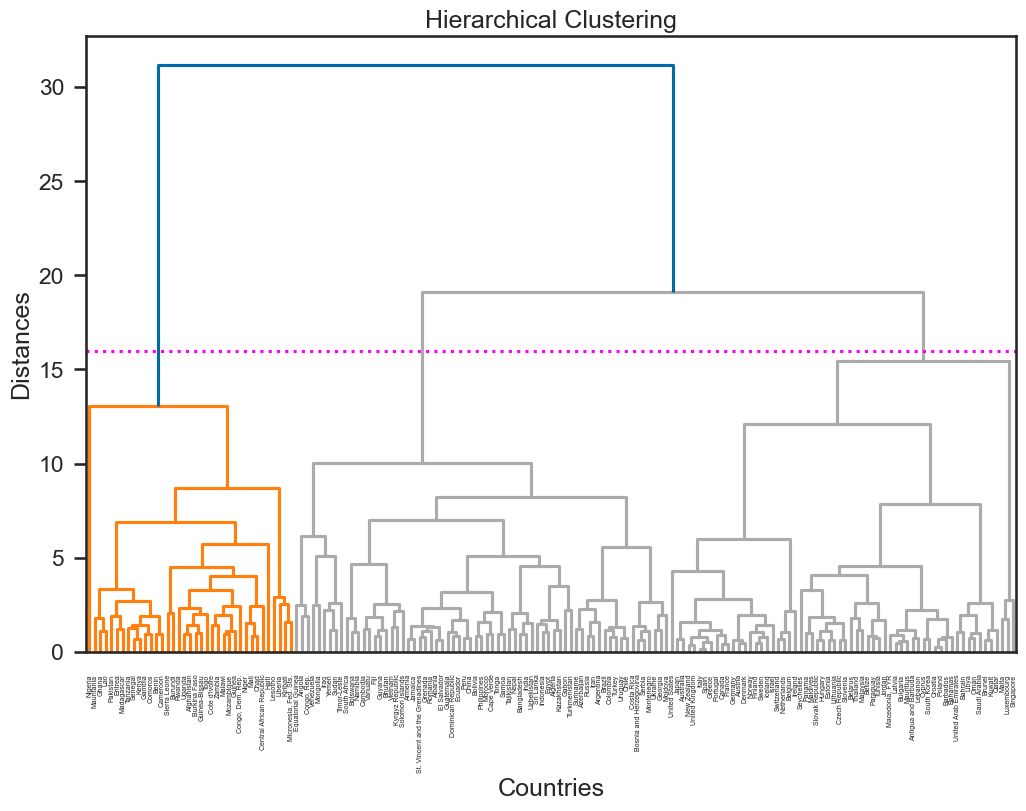

In [12]:
distance_threshold = 16 #Inserido após o 1º plot.

plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

linkage = sch.linkage(scaled_data, method="ward", optimal_ordering=True)
dendrogram = sch.dendrogram(linkage,labels=scaled_data.index)
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Countries')
ax.set_ylabel('Distances')
ax.axhline(distance_threshold, color='magenta', ls=":");

Um dendrograma é uma representação gráfica de uma análise de agrupamento hierárquico, em que os objetos (ou casos) são agrupados com base na sua similaridade ou dissimilaridade. O eixo vertical do dendrograma indica a medida de distância entre os objetos, enquanto o eixo horizontal mostra os objetos individuais ou grupos formados.

Aqui vemos que o dendograma apresenta dois grupos de Países com bastante similaridade  a parti da distância 20. Porém, como se é querido 3 clusters, temos que por volta da distância 16 temos a dissimilaridade ideal para formar 3 distintos clusters. 



**Clustermap**

Para melhor visualizar temos um hetmap, porém, devido ao tamanho do dataframe, não é possivel visualizar por completo. 

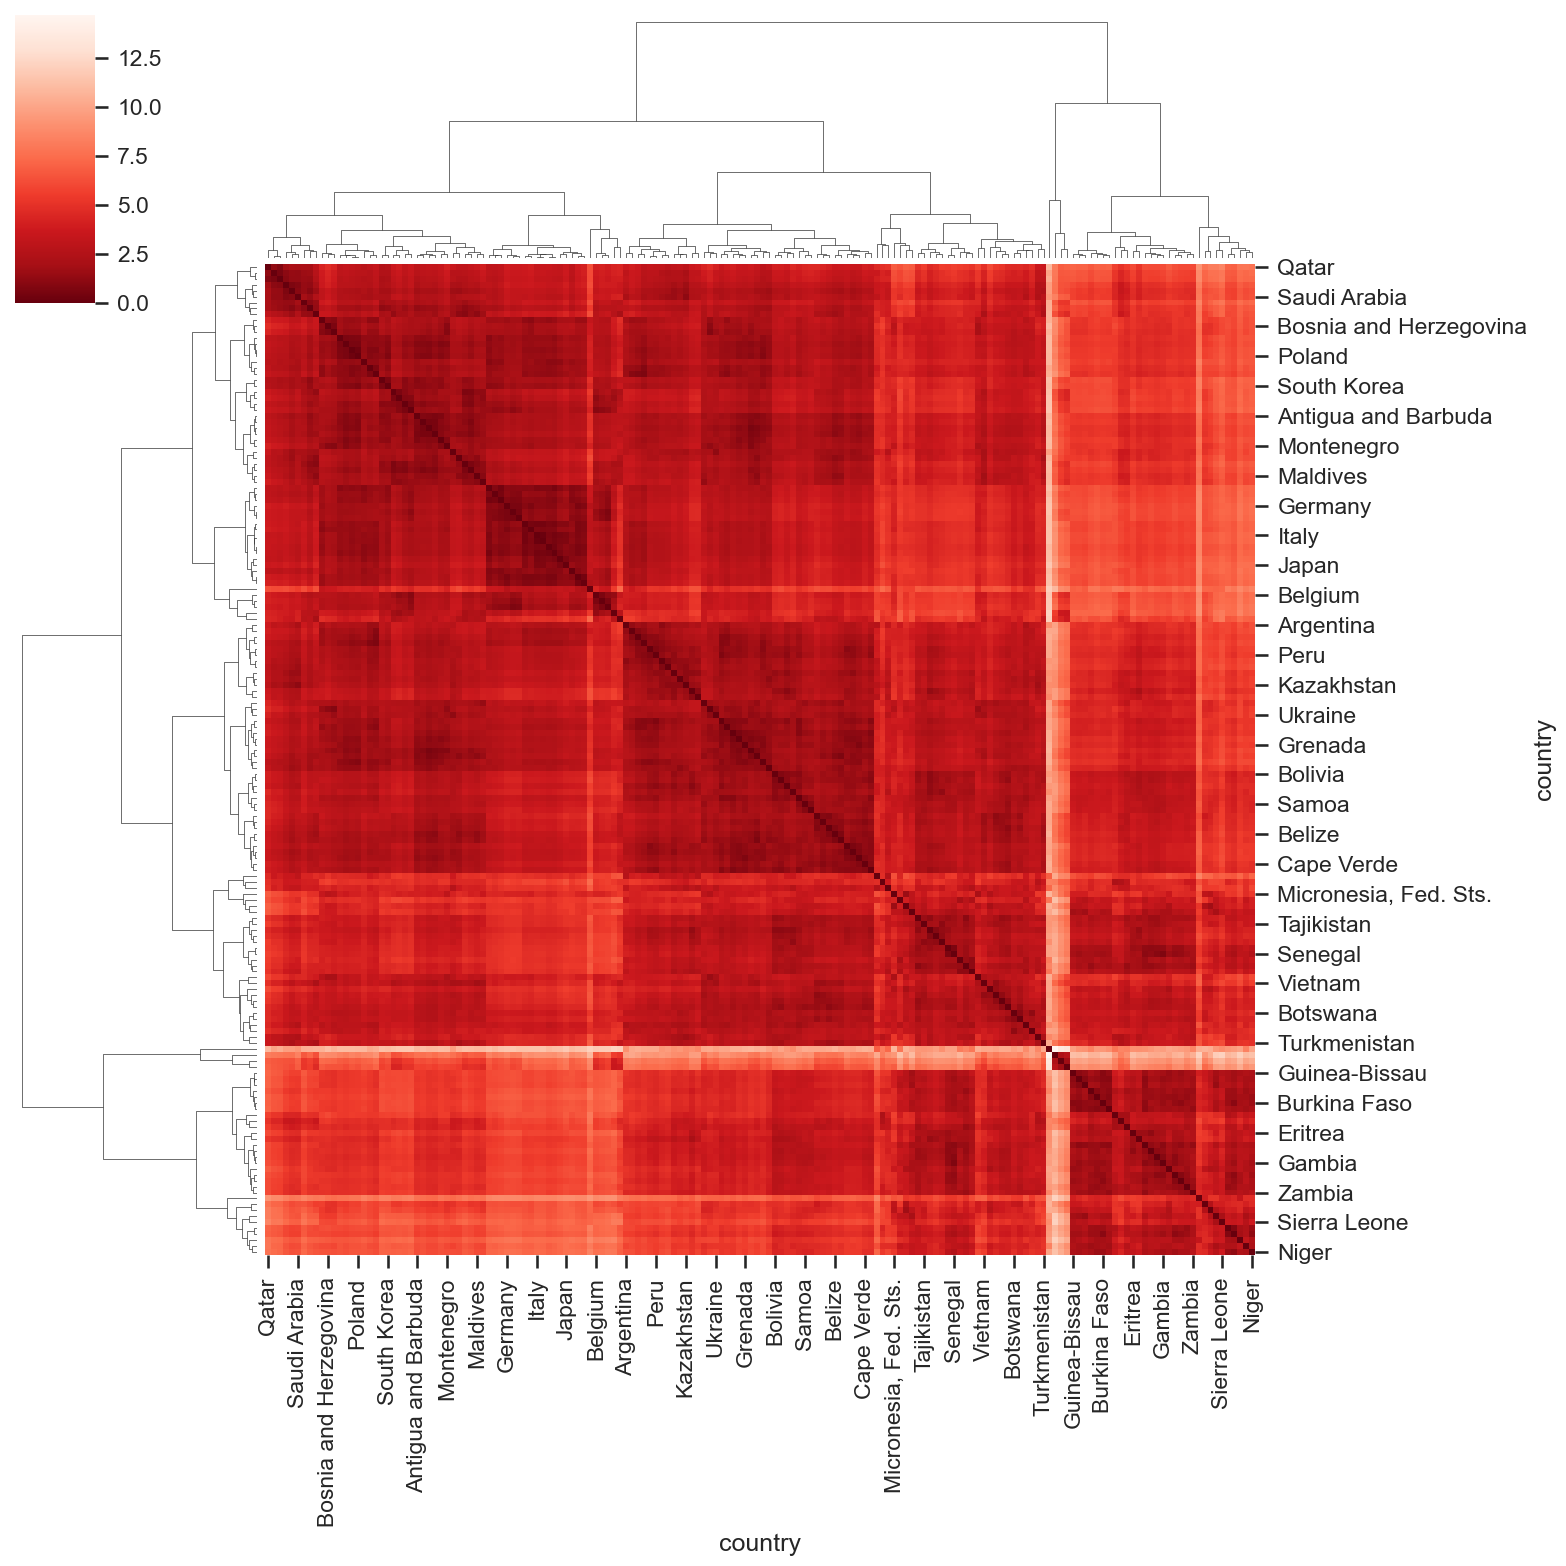

In [13]:
euclidean = DistanceMetric.get_metric('euclidean')

distances = euclidean.pairwise(scaled_data) 
distances = pd.DataFrame(distances, 
                         columns=scaled_data.index,
                         index=scaled_data.index)

sns.clustermap(distances, figsize=(16,16), cmap="Reds_r", method='ward');

O código abaixo faz a conferencia da forma que a clusterização hierarquica dividiu os clusters. Usamos como métrica label_ do metódo **AgglomerativeClustering**. 

Percebemos que a clusterização hierarquica formou seus clusters um pouco diferente do algoritimo KMeans.

Isso se dá provavelmente por essas observações abaixo:

*   A clusterização hierárquica executa uma segmentação dos dados de forma que cada item é um cluster em si mesmo, e posteriormente, os clusters são agrupados de acordo com sua similaridade até que haja apenas um único cluster. Esse processo pode ser feito de maneira aglomerativa, onde cada item é um cluster e são unidos em clusters cada vez maiores, ou de maneira divisiva, onde todos os itens estão no mesmo cluster e vão se dividindo em clusters menores.

*   Já o K-means utiliza uma abordagem iterativa para encontrar k clusters no conjunto de dados de entrada. O usuário deve definir previamente a quantidade de clusters que deseja obter, e o algoritmo organiza os dados de forma que cada ponto pertença ao cluster mais próximo do centróide (ponto médio do cluster). Em seguida, é recalculado o centróide de cada cluster e o processo se repete até que se alcance um critério de convergência.

*   A principal diferença é que na clusterização hierárquica não é preciso definir previamente o número de clusters, e pode-se visualizar graficamente todos os possíveis agrupamentos, enquanto no K-means é preciso definir o número de clusters antecipadamente. Além disso, a clusterização hierárquica é mais computacionalmente intensiva e pode ser mais lenta para grandes conjuntos de dados, enquanto o K-means é mais rápido e adequado para conjunto de dados maiores.


In [32]:
contador_hierar = dict(sorted(Counter(clusters_hierar).items()))
contador_kmeans = dict(sorted(Counter(clusters_kmeans).items()))


print(f"Clusters do Hierarquico: {contador_hierar}")
print(f"Clusters do Kmeans:      {contador_kmeans}")

Clusters do Hierarquico: {0: 62, 1: 37, 2: 67}
Clusters do Kmeans:      {0: 58, 1: 43, 2: 65}


**QUESTÃO - 04**

Compare os dois resultados, aponte as semelhanças e diferenças e interprete.

Usaremos o metódo **silhouette_score** para compararmos os dois modelos e ver qual neste caso teve melhor comportamento.

*output*-->

- Valor da métrica silhouette para clusterização k-means:  0.2358267763578767
- Valor da métrica silhouette para clusterização hierárquica:  0.2086427521300354

**Logo percebemos que a clusterização K-means teve melhor comportamento.**

In [11]:
kmeans_silhouette = silhouette_score(scaled_data, model_kmeans.labels_)
hierarchical_silhouette = silhouette_score(scaled_data, model_hierar.labels_)


print("Valor da métrica silhouette para clusterização k-means: ", kmeans_silhouette)
print("Valor da métrica silhouette para clusterização hierárquica: ", hierarchical_silhouette)

Valor da métrica silhouette para clusterização k-means:  0.23632890800240816
Valor da métrica silhouette para clusterização hierárquica:  0.3570453840464479


Distribuição dos Países nos dois modelos de clusterização=, K-Means e Clusterização Hierarquica.



In [34]:
kmean_total = dict(sorted(Counter(clusters_kmeans).items()))
print(f"""Distribuição dos clusters - KMeans:\n
      K_Means: {kmean_total}""")
print()

for i in range(3):

      print(f"""List of Countries in cluster {i}, total {kmean_total[i]} countries:
      \n       {str(df_cluster_scale[df_cluster_scale['clusters_kmeans']==i].index)[7:-40]}""")
      print('*'*80)


Distribuição dos clusters - KMeans:

      K_Means: {0: 58, 1: 43, 2: 65}

List of Countries in cluster 0, total 58 countries:
      
       'Antigua and Barbuda', 'Australia', 'Austria', 'Bahamas', 'Bahrain',
       'Barbados', 'Belgium', 'Bosnia and Herzegovina', 'Brunei', 'Bulgaria',
       'Canada', 'Chile', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kuwait',
       'Latvia', 'Lebanon', 'Lithuania', 'Luxembourg', 'Malaysia', 'Maldives',
       'Malta', 'Mauritius', 'Montenegro', 'Netherlands', 'New Zealand',
       'Norway', 'Panama', 'Poland', 'Portugal', 'Qatar', 'Serbia',
       'Seychelles', 'Singapore', 'Slovak Republic', 'Slovenia', 'South Korea',
       'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates',
       'United Kingdom', 'United States', 'Uruguay'
*******************************************************************

In [37]:
hierar_total = dict(sorted(Counter(clusters_hierar).items()))

print(f"""Distribuição dos clusters - Hierarquica:\n
      Hierarquica: {hierar_total}""")
print()

for i in range(3):
      print(f"""List of Countries in cluster {i}, total {hierar_total[i]} countries:
      \n       {str(df_cluster_scale[df_cluster_scale['clusters_hierar']==i].index)[7:-40]}""")
      print('*'*80)


Distribuição dos clusters - Hierarquica:

      Hierarquica: {0: 62, 1: 37, 2: 67}

List of Countries in cluster 0, total 62 countries:
      
       'Antigua and Barbuda', 'Australia', 'Austria', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Brunei', 'Bulgaria',
       'Canada', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Jordan', 'Kuwait', 'Latvia',
       'Lebanon', 'Libya', 'Lithuania', 'Luxembourg', 'Macedonia, FYR',
       'Malaysia', 'Maldives', 'Malta', 'Mauritius', 'Netherlands',
       'New Zealand', 'Norway', 'Oman', 'Panama', 'Paraguay', 'Poland',
       'Portugal', 'Qatar', 'Saudi Arabia', 'Seychelles', 'Singapore',
       'Slovak Republic', 'Slovenia', 'South Korea', 'Spain', 'Sweden',
       'Switzerland', 'Thailand', 'Tunisia', 'United Arab Emirates',
       'United Kingdom', 'United States'
******************

Ao observarmos os dois modelos vemos que há muitos Páises em comum acordo com a divisão do grupo de clusters, porem como vimos na silhueta, o K-means se mostrou superior.

**Escolha de algoritmos**

**QUESTÃO 01**

Escreva em tópicos as etapas do algoritmo de K-médias até sua convergência.

*    Inicializar k centróides em pontos aleatórios

*    Para cada ponto, encontrar qual o centróide mais próximo

*    Calcular o baricentro dos pontos para cada centróide

*    Mover o centróide na direção do seu baricentro

*    Repetir a partir de 2.

    - O algoritmo converge quando o movimento for menor que um valor pré-definido


**QUESTAO 02**

O algoritmo de K-médias converge até encontrar os centróides que melhor descrevem os clusters encontrados (até o deslocamento entre as interações dos centróides ser mínimo). Lembrando que o centróide é o baricentro do cluster em questão e não representa, em via de regra, um dado existente na base. 

Refaça o algoritmo apresentado na questão 1 a fim de garantir que o cluster seja representado pelo dado mais próximo ao seu baricentro em todas as iterações do algoritmo.
Obs: nesse novo algoritmo, o dado escolhido será chamado medóide.

*   Inicialize K centróides
*   Associe cada ponto ao centróide mais próximo (clusterização)
*   Encontre o ponto mais próximo do centróide em cada cluster
*   Substitua o centróide pelo ponto mais próximo para garantir que seja representado pelo dado mais próximo em cada iteração
*   Calcule a média para obter novos centróides

    ``` Repita os passos 2 a 5 até que não haja mudanças nos centróides.```
  

O código abaixo comprova o que realizamos em questões anterios. Esses são os medoides mais próximos dos centroides.

In [38]:
for i in range(3):

    df_medoid = df_cluster_scale[df_cluster_scale['clusters_kmeans']==i].drop(['clusters_kmeans','clusters_hierar'], axis=1)
    df_array_medoid= np.array(df_medoid) 

    KMobj = KMedoids(n_clusters=1).fit(df_array_medoid)

    kmedoid = KMobj.cluster_centers_.flatten().tolist()
    kmedoid = list(map(float, kmedoid))

    isin_filter = df_medoid.isin(kmedoid)
    row_filter = isin_filter.sum(axis=1) == len(kmedoid)
    linha_localizada = df_medoid.loc[row_filter]

    print(f" O Medoid do Cluster {i} é: {linha_localizada.index[0]}")  
   


 O Medoid do Cluster 0 é: South Korea
 O Medoid do Cluster 1 é: Tanzania
 O Medoid do Cluster 2 é: Jamaica


**QUESTÃO 03**

O algoritmo de K-médias é sensível a outliers nos dados. Explique.

O algoritmo de K-médias é um método de clustering que busca dividir um conjunto de dados em K grupos, de forma que cada observação seja alocada no grupo mais próximo da sua média. No entanto, esse método é sensível a outliers nos dados, pois a presença desses valores extremos pode distorcer a localização das médias e afetar negativamente a qualidade da clusterização.

Os outliers são, por definição, pontos que se afastam muito da maioria dos dados. Quando presentes, eles podem gerar grupos artificiais ou influenciar a formação dos clusters, levando a resultados imprecisos. Isso ocorre porque o algoritmo de K-médias utiliza a distância entre as observações e as médias como medida de similaridade, então os outliers podem criar distorções nessa medida e levar a uma alocação inadequada.

Portanto, antes de aplicar o algoritmo de K-médias, o conjunto de dados der ser analisado para identificar a presença de outliers e, se necessário, tratá-los antes de realizar a clusterização. Caso contrário, pode haver um comprometimento na eficácia do método.

**QUESTÃO 04**

Por que o algoritmo de DBScan é mais robusto à presença de outliers?

O algoritmo de DBScan é mais robusto à presença de outliers porque ele não utiliza a distância entre as observações e as médias como medida de similaridade, mas sim a densidade dos pontos no conjunto de dados. Ele define pontos centrais (core points) como aqueles que têm um número mínimo de vizinhos dentro de uma determinada distância (eps), e agrupa pontos próximos que pertencem a um mesmo conjunto densamente populado (cluster).

Os outliers, por definição, são pontos com baixa densidade e poucos vizinhos próximos. Quando o algoritmo de DBScan encontra esses pontos, ele os classifica como pontos de borda (border points) ou pontos de ruído (noise points), e não os agrupa com pontos mais próximos em clusters artificiais. Portanto, o algoritmo de DBScan é mais adequado para tratar dados com outliers e pode gerar resultados mais precisos em casos com distribuição espacial complexa.


**Conclusão**

Apesar de no projeto ter testados a preparação dos dados com excluão de outliers e também por meio de uso de PCA, preferi usar o modelo onde aplico log() nas variáveis *income* e *gdpp* e exclusão do outlier *Myanmar*, pois achei interessante a forma dque foi dividico os clusteres, tanto no modelo KMEANS como HIERÁRQUICO.